<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/HangboardProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import datetime as dt
from numpy import log
import pandas as pd
# df = pd.read_excel('MorganHB1.xlsx')
# df = pd.read_excel('TrevorHB.xlsx')
doc = 'https://github.com/Tclack88/MountainProject/blob/master/MorganHB.xlsx?raw=true'
doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB.xlsx?raw=true'
df = pd.read_excel(doc)
# df = pd.read_excel(doc)
name = doc.split('/')[-1].split('.')[0][:-2] # cheap way of getting climber name under assumption it's saved as "nameHB"
today = dt.datetime.today().strftime('%d %b %Y')

In [18]:
df

,date,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
0,26 Oct 2019,"0,6","-20,6","-45,6","-60,6","-50,6","-45,6","-55,6","-35,6","-45,6"
1,2019-10-29 00:00:00,"0,6","-17.5,5,5","-42.5,6","-57.5,6","-47.5,6","-42.5,6","-52.5,6","-32.5,6","-42.5,6"
2,2019-11-01 00:00:00,"0,6","-27.5,6","-40,6","-55,6","-45,6","-35,6","-50,6","-30,4,9,7","-40,5,6"
3,2019-11-04 00:00:00,"0,6","-27.5,6","-40,6","-55,6","-45,6","-35,6","-50,6","-30,6","-40,6"
4,2019-11-07 00:00:00,"0,6","-25,6","-37.5,6","-55,6","-42.5,6","-32.5,6","-47.5,6","-27.5,5,8","-37.5,5,9.5"
5,2019-11-10 00:00:00,"0,6","-22.5,6","-35,6","-52.5,6","-40,6","-30,6","-45,3,3,6,5","-25,4,5,8","-35,5,7"
6,2019-11-13 00:00:00,"0,6","-20,6","-32.5,6","-50,3,6,6,6","-37.5,6","-27.5,5,9","-42.5,3,9,6,7","-22.5,3,8,7,6","-32.5,4,8,7"
7,8 Feb 2020,"0,6","-30,6","-42.5,6","-57.5,6","-47.5,6","-37.5,6","-52.5,5,6","-32.5,3,9,6,8","-42.5,5,6"
8,11 Feb 2020,"0,6","-30,6","-42.5,6","-57.5,6","-47.5,6","-37.5,6","-52.5,6","-32.5,6","-42.5,6"
9,14 Feb 2020,"0,6","-27.5,6","-40,6","-57.5,6","-45,6","-35,6","-52.5,6","-30,5,7","-40,6"


In [19]:
df.date = pd.to_datetime(df.date)
df.date = pd.to_datetime(df.date, format = '%d %b %Y')

In [20]:
df = df.set_index('date')
df

,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
date,,,,,,,,,
2019-10-26,"0,6","-20,6","-45,6","-60,6","-50,6","-45,6","-55,6","-35,6","-45,6"
2019-10-29,"0,6","-17.5,5,5","-42.5,6","-57.5,6","-47.5,6","-42.5,6","-52.5,6","-32.5,6","-42.5,6"
2019-11-01,"0,6","-27.5,6","-40,6","-55,6","-45,6","-35,6","-50,6","-30,4,9,7","-40,5,6"
2019-11-04,"0,6","-27.5,6","-40,6","-55,6","-45,6","-35,6","-50,6","-30,6","-40,6"
2019-11-07,"0,6","-25,6","-37.5,6","-55,6","-42.5,6","-32.5,6","-47.5,6","-27.5,5,8","-37.5,5,9.5"
2019-11-10,"0,6","-22.5,6","-35,6","-52.5,6","-40,6","-30,6","-45,3,3,6,5","-25,4,5,8","-35,5,7"
2019-11-13,"0,6","-20,6","-32.5,6","-50,3,6,6,6","-37.5,6","-27.5,5,9","-42.5,3,9,6,7","-22.5,3,8,7,6","-32.5,4,8,7"
2020-02-08,"0,6","-30,6","-42.5,6","-57.5,6","-47.5,6","-37.5,6","-52.5,5,6","-32.5,3,9,6,8","-42.5,5,6"
2020-02-11,"0,6","-30,6","-42.5,6","-57.5,6","-47.5,6","-37.5,6","-52.5,6","-32.5,6","-42.5,6"


In [21]:
cols = df.columns
cols

Index(['jug', 'imr', 'med_edge', 'pinch_med', 'mr_2fp', 'large_edge',
       'pinch_wide', 'sloper', 'mrp_3fp'],
      dtype='object')

In [22]:
hangs = []
for col in cols:
  print('\n\n',col)
  column = df[col]
  inner_df = column.str.split(',', expand=True).fillna(0) # looks like an error happens if I don't first do this, pardon the redundancy
  if len(inner_df.columns) == 2:
    inner_df[2] = 0
    inner_df[3] = 60
    inner_df[4] = 0
  else:
    inner_df[1] = inner_df[1].apply(pd.to_numeric) # change to numeric columns
    print(inner_df.dtypes)
    inner_df.insert(2, 'fail', 6 - inner_df[1])
    inner_df.insert(3, 'TUT', 10*inner_df[1] + (inner_df.iloc[:,3:]).apply(pd.to_numeric).sum(axis=1))
    inner_df.insert(4, 'penalty_factor', log(7 - inner_df[1])/log(6)) #apply log base 6 as penalty factor (log(6,6) = 1.0 for failing all but one, log(6,1) = 0 for failing none
    inner_df = inner_df.iloc[:,:5]
  inner_df.columns = ['weight','success','fail','TUT','penalty_factor',]
  inner_df = inner_df[['weight','success','fail','TUT','penalty_factor']]
  inner_df = inner_df.apply(pd.to_numeric) # change to numeric columns
  inner_df.TUT = inner_df.TUT/60 # change TUT (Time under tension to a fraction of 60 seconds later for coloring)
  hang = inner_df[['weight','TUT','penalty_factor']]
  hang.index.name = 'Date'
  hang = hang.reset_index()
  hang['effective_weight'] = hang.weight - 2.5 * (hang.penalty_factor) - 2.5 * (1 - hang.TUT) # penalty of 2.5 lbs for low Time under tension and penalty for low total successful reps
  print(hang)
  hangs.append(hang)



 jug
         Date  weight  TUT  penalty_factor  effective_weight
0  2019-10-26       0  1.0               0               0.0
1  2019-10-29       0  1.0               0               0.0
2  2019-11-01       0  1.0               0               0.0
3  2019-11-04       0  1.0               0               0.0
4  2019-11-07       0  1.0               0               0.0
5  2019-11-10       0  1.0               0               0.0
6  2019-11-13       0  1.0               0               0.0
7  2020-02-08       0  1.0               0               0.0
8  2020-02-11       0  1.0               0               0.0
9  2020-02-14       0  1.0               0               0.0
10 2020-02-18       0  1.0               0               0.0
11 2020-02-21       0  1.0               0               0.0
12 2020-02-24       0  1.0               0               0.0
13 2020-02-27       0  1.0               0               0.0
14 2020-02-29       0  1.0               0               0.0
15 2020-03-04    

In [23]:
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [24]:
fig = go.Figure()

ending_weights = []

for hang in hangs:
  ending_weight = hang.effective_weight.to_list()[-1]
  ending_weights.append(ending_weight)
  fig.add_trace(go.Scatter(x=hang.index, y=hang.effective_weight, mode='lines+markers'))

# Adding labels
annotations = []
for ending_weight, col in zip(ending_weights, cols):
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=1, y=ending_weight,
                                  xanchor='left', yanchor='middle',
                                  text=f'{col}',
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
    
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Hangboard Progress',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1,
                              xanchor='left', yanchor='bottom',
                              text=f'{name} - as of {today}',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,
                  width = 1000,
                  height=800,
                  showlegend=False, # alternatively can show legend (default to True) and remove label on right
                  xaxis = dict(
                      tickmode = 'array',
                      tickvals = hang.index,
                      ticktext = hang.Date,
                      tickformat = '%y/%m'
                      ),
                  yaxis = dict(
                      tickmode = 'array',
                      title = 'weight (lbs from body weight)'
                      ))

fig.show()

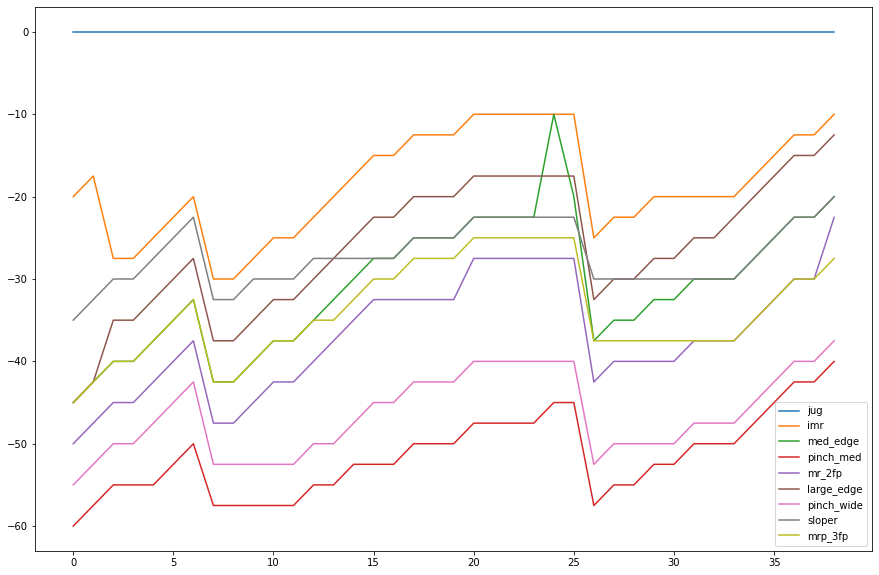

In [25]:
plt.figure(figsize=(15,10))
for hang in hangs:
  plt.plot(hang.index, hang.weight)

plt.legend(cols)
plt.show();